In [1]:
import pandas as pd
import re
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import numpy as np
import requests

In [110]:
# list to string
def ListToString(list):
    string_words = ' '.join(list)
    return string_words

In [111]:
# string to list
def StringToList(string):
    listRes = list(string.split(" "))
    return listRes

# Dataset

## Request data from web

In [42]:
import urllib
import urllib.request
from bs4 import BeautifulSoup

#define URL for scraping
theurl = "https://www.americanrhetoric.com/barackobamaspeeches.htm"
thepage = urllib.request.urlopen(theurl)

#Cooking the Soup
soup = BeautifulSoup(thepage,"html.parser")

web_list=[]
#Scraping "Link" (href)
for a_href in soup.find_all("a", href=True):
    #print(a_href["href"])
    web_list.append(a_href["href"])

In [3]:
speech=[]
for i in web_list:
    if i.startswith("speeches"):
        speech.append(i)
speech_web=[]
for i in speech:
    if i.endswith('htm'):
        speech_web.append(i)

In [9]:
start = speech_web.index('speeches/barackobama/barackobamainauguraladdress.htm')
speech_president = speech_web[start:]

# remove replicate
new = []
for i in speech_president:
    if i not in new:
        new.append(i)

speech_url = []
for val in range(len(new)):
    speech_url.append("https://www.americanrhetoric.com/" + str(new[val])) 

In [10]:
len(speech_url)

427

## List Title and Speeches

In [41]:
headers = {
      'User-Agent':"Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; rv:2.0.1) Gecko/20100101 Firefox/4.0.1"
}

def extract_text(url):
    resp = requests.get(url, headers=headers)
    s = BeautifulSoup(resp.text, "lxml")
    title = s.title
    text = s.get_text(strip=True)
    return title, text
#speech_content = [extract_text(url) for url in speech_url]

In [20]:
speeches = [extract_text(url) for url in speech_url]
len(speeches)

In [37]:
speech_content = []
speech_title = []

for i in range(len(speeches)):
    speech_content.append(speeches[i][1])
    speech_title.append(speeches[i][0])

In [38]:
def title(title):
    title = str(title)
    title = title[title.find("Obama -")+len("Obama -"):title.find("</title>")]
    #title = title[title.find("-")+len("-"):]
    title = title[:title.find("(transcript-audio-video)")]
    title = title[:title.find("(text-audio-video)")].strip()
    return title
speech_title = [title(x) for x in speech_title]

In [39]:
## delete something like cd, pdf ...
def allowed(speech):
    allowed = speech[speech.find("transcribed directly from audio]")
                        +len("transcribed directly from audio]"):speech.find(
                        "Book/CDs by Michael E. Eidenmuller,")].strip()
    return allowed

speech_content = [allowed(speech) for speech in speech_content]

## List Date ( 2009.01.20 – 2017.01.20 )

In [40]:
year = ["2009","2010","2011","2012","2013","2014","2015","2016","2017"]

In [71]:
date_list = []
for i in range(len(year)):
    date_list.extend(soup.find_all(string=re.compile(year[i])))

In [72]:
no = ['Press Conference on 2010 Budget Sent to Congress','Announcement of 2012 Presidential Candidacy',
     'Honoring Golden State Warriors 2015 NBA Champs','Press Conference Following 2016 NATO Summit']
for i in range(len(no)):
    date_list.remove(no[i])
len(date_list)

434

In [162]:
date = date_list[date_list.index("20 Jan 2009"):]

In [163]:
date = [str(x) for x in date]

## Create a Dataframe

In [164]:
df_speech = pd.DataFrame({'date': date,'title':speech_title,'content':speech_content}
                         )
df_speech.head()

,date,title,content
0,20 Jan 2009,First Presidential Inaugural Addre,"[Chief Justice John G. \r\n\t\tRoberts administers the Oath of Office]I, Barack Hussein Obama, d..."
1,24 Jan 2009,>American Rhetoric: Barack Obama: First Presidential Weekly Address \r\n(01-24-0,: First Presidential Weekly Address \r\n(01-24-09)BarackObamaFirst Presidential Weekly AddressFi...
2,26 Jan 2009,Al-Arabiya Television Intervi,- Al-Arabiya Television InterviewBarackObamaAl-Arabiya Television Interview With Hisham Melhemde...
3,04 Feb 2009,Remarks on Executive Compensati,- Remarks on Executive CompensationBarackObamaRemarks on the Economic \r\nCrisis & Executive Com...
4,09 Feb 2009,First Presidential Prime Time Press \r\nConferen,"Good \r\n\t\tevening, everybody. Please be seated.Before I take your questions \r\n\t\ttonight, ..."


In [165]:
df_speech.iloc[0,2] = df_speech.iloc[0,2][df_speech.iloc[0,2].find("My fellow citizens:")
                                          +len("My fellow citizens:"):df_speech.iloc[0,2].find("(Drudge Report)")]

In [166]:
## Make some edition
df_speech.iloc[1,2] = df_speech.iloc[1,2][df_speech.iloc[1,2].find("[as prepared for delivery]") + 
                                               len("[as prepared for delivery]"):]
df_speech.iloc[1,1] = df_speech.iloc[1,1][df_speech.iloc[1,1].find(">American Rhetoric: Barack Obama:")
                                         +len(">American Rhetoric: Barack Obama:"):df_speech.iloc[1,1].find(
                                         "(01-24-0")].strip()

In [167]:
df_speech.head(5)

,date,title,content
0,20 Jan 2009,First Presidential Inaugural Addre,"I stand here today humbled \r\n\t\tby the task before us, grateful for the trust you've bestowed..."
1,24 Jan 2009,First Presidential Weekly Address,We begin this year and this \r\n\t\tAdministration in the midst of an unprecedented crisis that ...
2,26 Jan 2009,Al-Arabiya Television Intervi,- Al-Arabiya Television InterviewBarackObamaAl-Arabiya Television Interview With Hisham Melhemde...
3,04 Feb 2009,Remarks on Executive Compensati,- Remarks on Executive CompensationBarackObamaRemarks on the Economic \r\nCrisis & Executive Com...
4,09 Feb 2009,First Presidential Prime Time Press \r\nConferen,"Good \r\n\t\tevening, everybody. Please be seated.Before I take your questions \r\n\t\ttonight, ..."


## Clean data

In [168]:
from nltk import WordNetLemmatizer
StopWords = stopwords.words("english")
StopWords.extend(["u","from"])

def clean_text(text):
    """
    This function takes as input a text on which several 
    NLTK algorithms will be applied in order to preprocess it
    """
    tokens = word_tokenize(text)
    # Remove the punctuations
    tokens = [word for word in tokens if word.isalpha()]
    # Lower the tokens
    tokens = [word.lower() for word in tokens]
    # Remove stopword
    tokens = [word for word in tokens if not word in StopWords]
    # Lemmatize
    lemma = WordNetLemmatizer()
    tokens = [lemma.lemmatize(word, pos = "v") for word in tokens]
    tokens = [lemma.lemmatize(word, pos = "n") for word in tokens]
    #list to string
    text = " ".join(tokens)
    return text

In [169]:
clean_content = [clean_text(i) for i in df_speech["content"].values.tolist() ]
df_speech["content_clean"] = clean_content
df_speech.head()

,date,title,content,content_clean
0,20 Jan 2009,First Presidential Inaugural Addre,"I stand here today humbled \r\n\t\tby the task before us, grateful for the trust you've bestowed...",stand today humble task u grateful trust bestow mindful sacrifice bear ancestor thank president ...
1,24 Jan 2009,First Presidential Weekly Address,We begin this year and this \r\n\t\tAdministration in the midst of an unprecedented crisis that ...,begin year administration midst unprecedented crisis call unprecedented action week saw people f...
2,26 Jan 2009,Al-Arabiya Television Intervi,- Al-Arabiya Television InterviewBarackObamaAl-Arabiya Television Interview With Hisham Melhemde...,television television interview hisham melhemdelivered january white house washington pdf authen...
3,04 Feb 2009,Remarks on Executive Compensati,- Remarks on Executive CompensationBarackObamaRemarks on the Economic \r\nCrisis & Executive Com...,remark executive compensationbarackobamaremarks economic crisis executive compensationdelivered ...
4,09 Feb 2009,First Presidential Prime Time Press \r\nConferen,"Good \r\n\t\tevening, everybody. Please be seated.Before I take your questions \r\n\t\ttonight, ...",good even everybody please take question tonight like speak briefly state economy believe need p...


In [170]:
# Extract nouns from speeches
def nouns_extract(cont):
    nouns = [] #empty to array to hold all nouns
    cont = StringToList(cont)
    for word,pos in nltk.pos_tag(cont):
        if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS'):
            nouns.append(word)
            string_nouns = ListToString(nouns)
    return string_nouns

nouns = [nouns_extract(x) for x in clean_content]
df_speech["content_nouns"] = nouns
df_speech.head(5)

,date,title,content,content_clean,content_nouns
0,20 Jan 2009,First Presidential Inaugural Addre,"I stand here today humbled \r\n\t\tby the task before us, grateful for the trust you've bestowed...",stand today humble task u grateful trust bestow mindful sacrifice bear ancestor thank president ...,stand today task u trust bestow sacrifice bear ancestor thank president service nation cooperati...
1,24 Jan 2009,First Presidential Weekly Address,We begin this year and this \r\n\t\tAdministration in the midst of an unprecedented crisis that ...,begin year administration midst unprecedented crisis call unprecedented action week saw people f...,year administration midst crisis call action week people unemployment time year nothing unemploy...
2,26 Jan 2009,Al-Arabiya Television Intervi,- Al-Arabiya Television InterviewBarackObamaAl-Arabiya Television Interview With Hisham Melhemde...,television television interview hisham melhemdelivered january white house washington pdf authen...,television television interview hisham house washington pdf authenticity version transcribe melh...
3,04 Feb 2009,Remarks on Executive Compensati,- Remarks on Executive CompensationBarackObamaRemarks on the Economic \r\nCrisis & Executive Com...,remark executive compensationbarackobamaremarks economic crisis executive compensationdelivered ...,remark executive compensationbarackobamaremarks crisis executive foyer browser support support a...
4,09 Feb 2009,First Presidential Prime Time Press \r\nConferen,"Good \r\n\t\tevening, everybody. Please be seated.Before I take your questions \r\n\t\ttonight, ...",good even everybody please take question tonight like speak briefly state economy believe need p...,question tonight speak briefly state economy need recovery plan motion trip elkhart indiana toda...


# K-means Cluster

## Train a model

In [ ]:
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing            import normalize
from sklearn import cluster
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics                  import silhouette_samples, silhouette_score
from wordcloud                        import WordCloud

# Map Viz
import folium
#import branca.colormap as cm
from branca.element import Figure

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_speech["content_nouns"])
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5, 0)

In [ ]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , random_state = 1
                               , algorithm = 'full')

        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results

def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))
        
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg):
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()
    
        
def silhouette(kmeans_dict, df, plot=False):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
        avg_dict.update( {silhouette_avg : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)

In [ ]:
# Running Kmeans
k = 20
kmeans_results = run_KMeans(k, final_df)

## Silhouette Analysis

In [ ]:
silhouette(kmeans_results, final_df, plot=True)

In [ ]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

In [ ]:
best_result = 15 ##need to be discussed
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

## Display

In [ ]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

In [ ]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

# Topic Modelling Time Series

## Set MALLET Path

In [171]:
path_to_mallet = 'mallet-2.0.8/bin/mallet'

## Install Packages

In [16]:
!pip3 install little_mallet_wrapper

## Import Packages

Now let's `import` the `little_mallet_wrapper` and the data viz library `seaborn`.

In [172]:
import little_mallet_wrapper
import seaborn
import glob
from pathlib import Path
import pandas as pd
import random
pd.options.display.max_colwidth = 100

### Process Speech

In [173]:
training_data = [little_mallet_wrapper.process_string(text, numbers='remove') for text in df_speech['content_nouns']]

### Get Original Speech

In [174]:
original_speech = [title for title in df_speech['content_clean']]

### Get Dataset Statistics

In [175]:
little_mallet_wrapper.print_dataset_stats(training_data)

Number of Documents: 427
Mean Number of Words per Document: 817.3
Vocabulary Size: 11759


## Training the Topic Model

We're going to train our topic model with the `little_mallet_wrapper.train_topic_model()` function.

So we have to set a few things up first.

### Set Number of Topics

We need to make a variable `num_topics` and assign it the number of topics we want returned.

In [176]:
num_topics = 30

### Set Training Data

We already made a variable called `training_data`, which includes all of our processed Reddit post texts, so we can just set it equal to itself.

In [177]:
training_data = training_data

### Set Other MALLET File Paths

Then we're going to set a file path where we want all our MALLET topic modeling data to be dumped.
All the other necessary variables below `output_directory_path` will be automatically created inside this directory.

In [178]:
#Change to your desired output directory
output_directory_path = 'topic-model-output'

#No need to change anything below here
Path(f"{output_directory_path}").mkdir(parents=True, exist_ok=True)

path_to_training_data           = f"{output_directory_path}/training.txt"
path_to_formatted_training_data = f"{output_directory_path}/mallet.training"
path_to_model                   = f"{output_directory_path}/mallet.model.{str(num_topics)}"
path_to_topic_keys              = f"{output_directory_path}/mallet.topic_keys.{str(num_topics)}"
path_to_topic_distributions     = f"{output_directory_path}/mallet.topic_distributions.{str(num_topics)}"

### Train Topic Model

Then we're going to train our topic model with `little_mallet_wrapper.quick_train_topic_model()`. The topic model should take about 1-1.5 minutes to train and complete. If you want it, you can look at your Terminal or PowerShell and see what the model looks like as it's training.

In [179]:
little_mallet_wrapper.quick_train_topic_model(path_to_mallet,
                                                                     output_directory_path,
                                                                     num_topics,
                                                                     training_data)

Importing data...
Complete
Training topic model...


Mallet LDA: 30 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 3972
total tokens: 348986
<10> LL/token: -8.74394
<20> LL/token: -8.31727
<30> LL/token: -8.17328
<40> LL/token: -8.10254

0	0.16667	law congress court system way issue case process justice vote rule time decision party debate reform program member number senator 
1	0.16667	veteran service secretary year time house care today meet team facility job fight leader family promise budget fund line folk 
2	0.16667	woman president society thing community justice progress change africa men person story man movement work poverty opportunity name sense law 
3	0.16667	iran weapon world peace security sanction deal israel state war year program threat treaty minister support negotiation time regime decade 
4	0.16667	war year nation woman force troop america men time world country mission home end iraq qaeda afghanistan part security state 
5	0.16667	country leader part time problem group help people something change que

<110> LL/token: -7.95542
<120> LL/token: -7.94104
<130> LL/token: -7.9333
<140> LL/token: -7.92993

0	0.16667	law court immigration vote reform process issue case rule justice party senate congress system judge politics debate member way democracy 
1	0.16667	veteran service leader today secretary care family work thank job serve woman mission time house congress morning meet facility mark 
2	0.16667	woman justice africa men change progress society movement community thing example girl person law opportunity man poverty life police health 
3	0.16667	iran weapon deal state sanction security world israel peace year program region decade war support use regime threat negotiation interest 
4	0.16667	war year force nation troop woman time america support country men state home mission iraq end security world qaeda afghanistan 
5	0.16667	country world leader people help question change part climate group start way problem everybody try year end work conflict level 
6	0.16667	governor romney p

[beta: 0.01407] 
<210> LL/token: -7.90056
[beta: 0.01505] 
<220> LL/token: -7.91604
[beta: 0.01539] 
<230> LL/token: -7.91217
[beta: 0.01559] 
<240> LL/token: -7.91262

0	0.18559	law court immigration vote reform rule justice judge system party case process senate issue democracy debate constitution member border politics 
1	0.1321	veteran service today care secretary family job thank priority work need marine facility serve generation morning budget step leader member 
2	0.13793	woman justice africa men progress law movement society police change community girl prison promise opportunity person man crime health care 
3	0.11334	iran weapon deal security israel sanction year state peace world program region war regime support time use decade threat negotiation 
4	0.32087	war year force troop woman nation america support mission men home time country iraq end security world state afghanistan leadership 
5	0.16575	country world change question part leader help year climate group people or

[beta: 0.0157] 
<310> LL/token: -7.88634
[beta: 0.0159] 
<320> LL/token: -7.88646
[beta: 0.01601] 
<330> LL/token: -7.88099
[beta: 0.01602] 
<340> LL/token: -7.87331

0	0.11545	law court justice judge rule process debate issue vote case constitution democracy decision party politics program senate candidate enforcement view 
1	0.09501	veteran service care secretary today budget congress generation facility defense marine claim serve need morning family job shinseki brain staff 
2	0.10666	woman men justice africa progress law community change society movement girl promise police right kenya prison history country violence march 
3	0.11158	iran weapon deal sanction israel security world year program state peace region regime arm threat time treaty decade negotiation bomb 
4	0.38757	war year force woman troop security time men nation america mission iraq support home state end afghanistan fight country leadership 
5	0.11207	country world change climate leader question year people group ca

[beta: 0.01629] 
<410> LL/token: -7.84493
[beta: 0.01616] 
<420> LL/token: -7.84344
[beta: 0.01626] 
<430> LL/token: -7.8413
[beta: 0.01639] 
<440> LL/token: -7.84344

0	0.08586	court law justice judge case program process rule constitution democracy vote debate view decision society senate issue person party crime 
1	0.07061	veteran service care secretary today marine budget honor facility morning serve shinseki defense congress claim health brain staff decade family 
2	0.0904	woman justice men africa community law movement police girl society progress change right race promise kenya history school somebody gap 
3	0.10306	iran weapon deal israel sanction security state program world year region peace regime agreement threat negotiation arm issue time fact 
4	0.38724	war force year troop security nation mission men woman america iraq time support home end afghanistan fight sacrifice leadership service 
5	0.09332	country world climate change question people leader part group society dev

[beta: 0.01647] 
<510> LL/token: -7.80896
[beta: 0.01656] 
<520> LL/token: -7.80986
[beta: 0.01642] 
<530> LL/token: -7.80513
[beta: 0.01657] 
<540> LL/token: -7.80454

0	0.08541	court law justice judge case process rule prison democracy vote constitution sentence program crime issue view attorney society senate debate 
1	0.06736	veteran service care secretary facility job family today congress woman marine shinseki budget priority generation claim morning ship serve hire 
2	0.08004	woman men community justice africa law police society girl change movement progress right kenya school half march organization discrimination slavery 
3	0.09342	iran weapon deal israel sanction security program world state year region threat peace regime agreement negotiation support decade time arm 
4	0.32809	war force troop year men america time woman mission security nation iraq home afghanistan support fight sacrifice leadership qaeda attack 
5	0.06995	country question climate people change world leader

[beta: 0.01668] 
<610> LL/token: -7.79514
[beta: 0.01667] 
<620> LL/token: -7.78937
[beta: 0.01668] 
<630> LL/token: -7.79618
[beta: 0.01667] 
<640> LL/token: -7.78749

0	0.07884	court law justice judge process case constitution issue prison crime debate rule attorney sentence person view release program democracy drug 
1	0.05511	veteran service care secretary facility today marine budget shinseki claim serve staff congress generation benefit brain coast health record chairman 
2	0.07241	woman community police men justice law movement girl society right africa change progress kenya race march policy violence officer promise 
3	0.08317	iran weapon deal sanction israel security world program state region year peace agreement regime threat negotiation minister time arm material 
4	0.32578	war force troop nation security year iraq america men mission time support afghanistan world home woman end fight leadership sacrifice 
5	0.06112	country question people climate world change state region

[beta: 0.01682] 
<710> LL/token: -7.78696
[beta: 0.01675] 
<720> LL/token: -7.7878
[beta: 0.01678] 
<730> LL/token: -7.78558
[beta: 0.01679] 
<740> LL/token: -7.7849

0	0.08914	court law justice judge case rule process prison constitution attorney sentence society time democracy crime view debate responsibility release drug 
1	0.06468	veteran service care secretary marine facility generation job shinseki budget congress serve benefit claim staff war vet hire vietnam record 
2	0.07708	woman community police justice law girl africa movement right progress men kenya man race violence society march somebody discrimination officer 
3	0.09907	iran deal weapon security sanction israel state region program world peace year regime agreement threat negotiation issue minister arm opportunity 
4	0.29075	war force year troop nation security mission woman men iraq america time afghanistan world leadership end fight sacrifice partner support 
5	0.06746	country question people change world climate lea

[beta: 0.01703] 
<810> LL/token: -7.78559
[beta: 0.01704] 
<820> LL/token: -7.78303
[beta: 0.01705] 
<830> LL/token: -7.7814
[beta: 0.01704] 
<840> LL/token: -7.78567

0	0.06783	court law justice case judge prison crime constitution process attorney vote society program debate view sentence rule drug release incarceration 
1	0.07243	veteran service care secretary marine staff need serve shinseki facility respect claim hire coast war ship health vietnam budget benefit 
2	0.06569	woman police community law justice africa movement progress change girl kenya race march right men officer promise society violence equality 
3	0.09062	iran weapon deal sanction israel security state world program peace region year threat minister regime time agreement arm negotiation decade 
4	0.28397	war force year troop security mission nation iraq men america home fight afghanistan woman time leadership end support world qaeda 
5	0.06725	country state question leader change people world climate society oppor

[beta: 0.01686] 
<910> LL/token: -7.77254
[beta: 0.01693] 
<920> LL/token: -7.7756
[beta: 0.01695] 
<930> LL/token: -7.7769
[beta: 0.01699] 
<940> LL/token: -7.77423

0	0.08902	court law justice case judge prison process rule attorney vote constitution crime sentence democracy system view person society senate issue 
1	0.06443	veteran service care marine secretary facility job serve claim health shinseki generation morning benefit troop staff respect brain budget decade 
2	0.06258	woman community police law justice movement men progress change africa girl kenya officer violence history march right race society organization 
3	0.08456	iran weapon deal sanction security israel peace state program region world year regime minister time threat decade arm agreement negotiation 
4	0.29501	war force troop security mission men year woman nation iraq time america end home afghanistan sacrifice qaeda attack world support 
5	0.06296	country people question state leader government region world soc

Complete


([['court',
   'law',
   'justice',
   'judge',
   'case',
   'prison',
   'process',
   'crime',
   'program',
   'sentence',
   'rule',
   'constitution',
   'vote',
   'drug',
   'attorney',
   'release',
   'society',
   'incarceration',
   'someone',
   'person'],
  ['veteran',
   'service',
   'care',
   'secretary',
   'marine',
   'facility',
   'health',
   'shinseki',
   'budget',
   'serve',
   'congress',
   'respect',
   'claim',
   'benefit',
   'record',
   'promise',
   'morning',
   'generation',
   'vet',
   'cory'],
  ['woman',
   'police',
   'community',
   'men',
   'justice',
   'movement',
   'change',
   'progress',
   'law',
   'race',
   'girl',
   'officer',
   'kenya',
   'march',
   'history',
   'right',
   'discrimination',
   'protest',
   'shape',
   'dallas'],
  ['iran',
   'weapon',
   'deal',
   'security',
   'sanction',
   'israel',
   'world',
   'region',
   'program',
   'state',
   'year',
   'peace',
   'minister',
   'agreement',
   'regime'

## Display Topics and Top Words

In [180]:
topics = little_mallet_wrapper.load_topic_keys(path_to_topic_keys)

for topic_number, topic in enumerate(topics):
    print(f"✨Topic {topic_number}✨\n\n{topic}\n")

✨Topic 0✨

['court', 'law', 'justice', 'judge', 'case', 'prison', 'process', 'crime', 'program', 'sentence', 'rule', 'constitution', 'vote', 'drug', 'attorney', 'release', 'society', 'incarceration', 'someone', 'person']

✨Topic 1✨

['veteran', 'service', 'care', 'secretary', 'marine', 'facility', 'health', 'shinseki', 'budget', 'serve', 'congress', 'respect', 'claim', 'benefit', 'record', 'promise', 'morning', 'generation', 'vet', 'cory']

✨Topic 2✨

['woman', 'police', 'community', 'men', 'justice', 'movement', 'change', 'progress', 'law', 'race', 'girl', 'officer', 'kenya', 'march', 'history', 'right', 'discrimination', 'protest', 'shape', 'dallas']

✨Topic 3✨

['iran', 'weapon', 'deal', 'security', 'sanction', 'israel', 'world', 'region', 'program', 'state', 'year', 'peace', 'minister', 'agreement', 'regime', 'threat', 'decade', 'arm', 'interest', 'issue']

✨Topic 4✨

['war', 'force', 'troop', 'security', 'mission', 'year', 'iraq', 'men', 'woman', 'america', 'nation', 'afghanistan'

## Display Top Speech For Topic

### Load Topic Distributions

In [181]:
topic_distributions = little_mallet_wrapper.load_topic_distributions(path_to_topic_distributions)

In [182]:
speech_dict = dict(zip(training_data, original_speech))

In [183]:
def display_top_speech_per_topic(topic_number=0, number_of_documents=5):
    
    print(f"✨Topic {topic_number}✨\n\n{topics[topic_number]}\n")

    for probability, document in little_mallet_wrapper.get_top_docs(training_data, topic_distributions, topic_number, n=number_of_documents):
        print(round(probability, 4), speech_dict[document] + "\n")
    return

Here, we can use the function to find out speeches related to each topic

In [184]:
display_top_speech_per_topic(topic_number=1, number_of_documents=5)

✨Topic 1✨

['veteran', 'service', 'care', 'secretary', 'marine', 'facility', 'health', 'shinseki', 'budget', 'serve', 'congress', 'respect', 'claim', 'benefit', 'record', 'promise', 'morning', 'generation', 'vet', 'cory']

0.3512 good morning everybody minute ago secretary shinsekiand rob nabors temporarily assign work va present initial review va facility nationwide find misconduct limit va facility many across country totally unacceptable veteran deserve best earn last week say find misconduct would punish mean shinseki begin process fire many people responsible include senior leader phoenix cancel possible performance bonus year vha senior executive order va personally contact every veteran phoenix wait appointment get care need morning think also hear ric shinseki take truly remarkable action public remark take responsibility conduct facility apologize fellow veteran american people minute ago secretary shinseki offer resignation considerable regret shinseki serve country honor nea

### Show Topic Words in Context of Full Speech

In [185]:
from IPython.display import Markdown, display
import re

def display_bolded_topic_words_in_context(topic_number=3, number_of_documents=3, custom_words=None):

    print(f"✨Topic {topic_number}✨\n\n{topics[topic_number]}\n")

    for probability, document in little_mallet_wrapper.get_top_docs(training_data, topic_distributions, topic_number, n=number_of_documents):

        probability = f"✨✨✨\n\n**{probability}**"
        original_text = speech_dict[document]
        original_text_lowered = original_text.lower()
        topic_words = topics[topic_number]
        topic_words = custom_words if custom_words != None else topic_words

        for word in topic_words:
            if word in original_text_lowered:
                original_text = re.sub(f"\\b{word}\\b", f"**{word.upper()}**", original_text, flags=re.I)

        display(Markdown(probability)), display(Markdown(original_text))
    return

In [186]:
display_bolded_topic_words_in_context(topic_number=1, number_of_documents=4)

✨Topic 1✨

['veteran', 'service', 'care', 'secretary', 'marine', 'facility', 'health', 'shinseki', 'budget', 'serve', 'congress', 'respect', 'claim', 'benefit', 'record', 'promise', 'morning', 'generation', 'vet', 'cory']



✨✨✨

**0.3512442902308997**

good **MORNING** everybody minute ago **SECRETARY** shinsekiand rob nabors temporarily assign work va present initial review va **FACILITY** nationwide find misconduct limit va **FACILITY** many across country totally unacceptable **VETERAN** deserve best earn last week say find misconduct would punish mean **SHINSEKI** begin process fire many people responsible include senior leader phoenix cancel possible performance bonus year vha senior executive order va personally contact every **VETERAN** phoenix wait appointment get **CARE** need **MORNING** think also hear ric **SHINSEKI** take truly remarkable action public remark take responsibility conduct **FACILITY** apologize fellow **VETERAN** american people minute ago **SECRETARY** **SHINSEKI** offer resignation considerable regret **SHINSEKI** **SERVE** country honor nearly year two tour combat vietnam **VETERAN** leave part battlefield rise command first cavalry division **SERVE** army chief staff never afraid speak truth **SECRETARY** va preside **RECORD** investment **VETERAN** enrol million new **VETERAN** **HEALTH** **CARE** deliver disability pay vietnam **VETERAN** expose agent orange make easier **VETERAN** stress mental **HEALTH** issue traumatic brain injury get treatment improve **CARE** woman **VETERAN** time help reduce **VETERAN** homelessness help million **VETERAN** servicemembers family pursue education gi commitment **VETERAN** unquestioned **SERVICE** country exemplary grateful **SERVICE** many **VETERAN** across country work hard investigate identify problem access **CARE** tell **MORNING** va need new leadership address want distraction priority fix problem make sure **VET** get **CARE** need judgment behalf fellow **VETERAN** agree time distraction need fix leader help move u forward issloan gibson take rein act **SECRETARY** sloan become deputy **SECRETARY** va three month ago devote life **SERVE** country **VETERAN** grandfather fight front line world war father world war ii sloan graduate west point earn airborne ranger qualification **SERVE** infantry recently president ceo uso remarkable job support men woman war family wound warrior family tell sloan year private sector nonprofit experience bring bear ongoing work build century grateful will take meet sloan meet ric **MORNING** make clear reform wait need proceed immediately also ask rob nabors stay va temporarily help sloan department transition complete review vha meantime go look diligently new permanent va **SECRETARY** hope confirm successor fill post soon go right **VETERAN** across board long take go stop work make sure get **CARE** **BENEFIT** opportunity earn deserve say tolerate misconduct say better many **VETERAN** receive **CARE** right deserve best effort honest assessment something week visit men woman uniform different stag **SERVICE** newest army officer graduate west point troop currently **SERVE** afghanistan **VETERAN** military family arlington saw see every single servicemember **VETERAN** military spouse privilege meet selfless commitment **SERVE** country best way know best country offer duty expect u today want every man woman **SERVE** flag know whether tour decade end never stop work right take couple question leo shane military president change opinion **SECRETARY** **SHINSEKI** last day say confidence even come today say time resign make difference mind president obama judgment think belief would distraction task hand make sure break get fix fellow **VETERAN** get **SERVICE** want reiterate good man mean accomplish man mean outstanding soldier good person do exemplary work behalf leadership see progress front va bigger investment va va **SECRETARY** cut homelessness percent bring folk expose agent orange wait decade get **SERVICE** **BENEFIT** earn make sure stress disorder traumatic brain injury deal serious way make sure **FACILITY** woman **VET** often receive kind specialize **SERVICE** champion **VETERAN** problem ready will get fix disability backlog shoot consequence admission agent orange **VETERAN** well make easier apply stress disorder disability **CLAIM** spike go systematic way cut percent course last year adverse admit problem go occupy environment call management fix also get deal **CONGRESS** think judgment could carry next stag reform without distraction assessment unfortunately right regret resign circumstance also confidence sloan share ric assessment priority make sure problem get fix **VETERAN** need help get schedule able come see doctor **FACILITY** enough doctor enough nurse enough space information immediately get hand way way **CONGRESS** get resource help seem biggest problem think thing offend **SECRETARY** **SHINSEKI** course process describe fact theater might order attack base phone call corporal get trust get good information life death think deeply disappoint fact bad news get structure place identify problem quickly fix priority make sure happen felt like new leadership would would **SERVE** **VETERAN** best agree thank president base audit least early stage audit **SECRETARY** present sense criminal wrongdoing guess broadly much responsibility personally bear issue campaign **CARE** deeply say **CARE** deeply administration point president obama well leave justice department make determination term whether criminal wrongdoing term responsibility say administration always take responsibility whatever happen area particular concern predate presidency senate **VETERAN** affair committee hear firsthand **VETERAN** get kind **SERVICE** **BENEFIT** earn pledge privilege **SERVE** president would fix va big organization problem long time case management problem case fund problem try systematically go problem aware fix see **VETERAN** properly **SERVE** whether many homeless **VETERAN** disability **CLAIM** process take long would go chip away fix come fund increase fund va **SERVICE** unprecedented fashion understand enough give lip **SERVICE** **VETERAN** will put money mouth say confidently priority priority reflect **BUDGET** term manage va see problem aware problem go fix able make significant absolutely clear one issue schedule one report system inside vha surface level ric aware able see something hear travel around country particular issue schedule go part review go see make sure get information system talk rob nabors describe example specific detail **FACILITY** get computer system schedule date back situation one scheduler might look four five different screen figure slot might doctor available situation manually pas request appointment somebody else inputting right many case old system stuff eminently fixable get know big concern get go interest find number **FACILITY** fact **VETERAN** wait long appointment information surface sooner could go ahead fix last point want make **VETERAN** get access system **HEALTH** **CARE** receive get high mark **VETERAN** **SERVICE** organization **VETERAN** think important keep mind review indicate far least great stride make actual **CARE** provide **VETERAN** challenge get **VETERAN** door particularly first appointment case establish relationship doctor go technology part management ric **SHINSEKI** indicate need change culture within vha perhaps vha whole va whole make sure bad news get surface quickly thing fix know attitude **SECRETARY** **SHINSEKI** communicate folk execute parson last thank president say judgment make decision remember correctly **SECRETARY** sebelius offer resignation fail decline take wonder little bite scapegoating take place obama mean question mean mean dysfunction within department seem deep obama lop head really best step take go forward ask political reason remove go straight problem bureaucracy president obama well distraction ric refer part political need stage want somebody va spend time outside solve problem **VETERAN** want somebody spend every minute every day figure call every single **VETERAN** wait get schedule fix system kind new technology need make realistic assessment long wait time right go bring wait time certain **FACILITY** wait time long need money much money need ask **CONGRESS** go make sure **CONGRESS** deliver additional want somebody va focus get speculation future forth ric agree **RESPECT** **SECRETARY** sebelius time think would distraction replace somebody hhs time try fix system want stay focus know bear get folk enrol would instance primary decision base deliver **SERVICE** american people case deliver **VETERAN** people integrity think case **SECRETARY** sebelius certainly case ric **SHINSEKI** get priority view go best deliver behalf folk ric say **MORNING** let remember time felt much knowledge go wrong afford lose obama somebody three month leadership department capacity attack problem quickly president obama well go need new va **SECRETARY** sloan act sloan think would first acknowledge go learn curve get deal nature problem surface cause attention one start tackle right away without completely transform system immediately make progress go issue go take **CARE** first step everybody wait get appointment need doctor figure surge doctor make sure get help need want make sure even still patchwork make sure slippage somebody make phone call get appointment schedule realistic time soon go get appointment thing require rocket science require execution require discipline require focus thing sloan go broader issue go tackle information system inside vha probably go change cost money take time implement think go change culture within vha say provide good **SERVICE** medical treatment **VETERAN** get system apparently operation would want see example major medical center keep mind u outside va system try get appointment doctor private sector try get appointment schedule hospital visit probably wait time well part figure realistic benchmark suspicion **VETERAN** iraq afghanistan come back also age vietnam **VET** may chronic illness may need visit may need get doctor may need get nurse go cost money mean go reflect **VETERAN** affair **BUDGET** consistently increase even fiscally tight time area put priority make sure deliver kind **BUDGET** necessary make sure **VETERAN** **SERVE** may still go start spend money first job take **CARE** basic management issue think right thank

✨✨✨

**0.30275897616463365**

good **MORNING** everybody meet **SECRETARY** **SHINSEKI** rob nabors temporarily assign work **SECRETARY** **SHINSEKI** focus two issue allegation misconduct **VETERAN** affair **FACILITY** broader mission **CARE** **VETERAN** honor stand men woman uniform every step **SERVICE** moment take oath troop prepare deploy afghanistan put live line security bedside wound warrior fight recover terrible injury sear moment presidency go walter reed bethesda bagram meet troop leave part battlefield spirit determination recover often **SERVE** men woman family best country offer do duty ask nothing country uphold sacred trust hear allegation misconduct misconduct whether allegation va staff cover long wait time cook book stand also american none u allegation prove true dishonorable disgraceful tolerate discus **SECRETARY** **SHINSEKI** **MORNING** first anybody find manipulate falsify **RECORD** va **FACILITY** hold accountable inspector general va launch investigation phoenix va **FACILITY** individual already put administrative leave know people angry want swift reckon sympathize let investigator job get bottom happen **VETERAN** deserve know fact family deserve know fact know fact assure misconduct want know full scope problem order **SECRETARY** **SHINSEKI** investigate today update review look phoenix **FACILITY** also va **FACILITY** across nation expect preliminary result review next direct rob nabors conduct broader review **VETERAN** **HEALTH** administration part va deliver **HEALTH** **CARE** **VETERAN** rob go phoenix today keep mind though even hear report phoenix **FACILITY** **FACILITY** know often take long **VETERAN** get **CARE** need new development problem decade compound decade come office say would systematically work fix problem work really hard address attitude folk fight battlefield fight bureaucracy home get **CARE** presumption always get better review comprehensive look **VETERAN** **HEALTH** approach currently access **CARE** want know work want know work want specific recommendation va game expect full report rob next four say expect everyone involve work **CONGRESS** important oversight role play welcome **CONGRESS** partner effort address current controversy make sure right **VETERAN** across board **SERVE** **VETERAN** affair committee senate one proudest piece business legislature know folk **CARE** deeply important **VETERAN** become another political football especially many receive **CARE** right area democrat republican always work bring final point even get bottom happen phoenix **FACILITY** u whether washington across country stay focus larger mission uphold sacred trust **VETERAN** bring va system century easy make progress last five year make historic investment **VETERAN** boost va fund **RECORD** level create consistency advance appropriation **VETERAN** organization know money would regardless political wrangle make va **BENEFIT** available million **VETERAN** deliver disability pay vietnam **VET** expose agent orange make easier **VETERAN** stress mental **HEALTH** issue traumatic brain injury get treatment improve **CARE** woman step influx new **VETERAN** require **SERVICE** add many case wait time launch war disability **CLAIM** backlog past year alone slash backlog course go let still high go keep eliminate backlog meanwhile also reduce homelessness among **VETERAN** help **VETERAN** family million far pursue education gi bill step effort help newest **VETERAN** get skill train find job come home along michelle jill biden join force help hundred thousand **VETERAN** find job **VETERAN** find work **VETERAN** unemployment although still way high come point **CARE** **VETERAN** issue pop recent week problem **RESPECT** **VETERAN** able access **BENEFIT** earn new issue issue work run unite state senate take **CARE** **VETERAN** family one cause presidency something u involve pay attention end war iraq war afghanistan end newest **VETERAN** come home demand va go grow go redouble effort get right nation honest continue area get lot today want every **VETERAN** know go fix whatever wrong long privilege **SERVE** go keep fight deliver **CARE** **BENEFIT** opportunity family deserve decade come commitment feel sacred duty go take two question go take jim kuhnhenn ap first thank president say cause presidency run issue mention allow get stage actually potentially **VETERAN** die wait treatment extreme circumstance get president obama well find first exactly happen want get ahead ig report investigation do think important recognize wait time generally ig indicate far least wait time folk may chronic condition seek next appointment may already receive **SERVICE** necessarily situation call emergency **SERVICE** ig indicate see link wait actually excuse fact wait time general long **FACILITY** find exactly happen find realistically cut wait time large influx new **VETERAN** come get population **VETERAN** also age part baby boom population get make sure schedule system access system thing sync part va **HEALTH** **CARE** system perform see example satisfaction rat many **FACILITY** **RESPECT** many provider high see term folk get schedule get system still many problem go get complete report consequence people **CARE** problem million appointment schedule among **VETERAN** course year lot appointment mean get system build order able take folk smooth fashion know expect reliable mean va get set standard meet meet right go set realistic goal improve system responsibility ultimately rest general **SHINSEKI** president obama know responsibility thing always rest ultimately president ric **SHINSEKI** great soldier disable **VETERAN** nobody **CARE** **VETERAN** ric **SHINSEKI** ask think ric **SHINSEKI** perform overall would say homelessness gi bill work u reduce backlog across board put heart soul thing take say ric say today want see result report go accountability go expect even report do see significant improvement term admission process take place va **HEALTH** **CARE** **FACILITY** know **CARE** deeply great public servant great warrior behalf unite state america go work solve problem go make sure accountability throughout system get full holland thank sir **SECRETARY** **SHINSEKI** offer resign blame catch surprise allegation president obama ric **SHINSEKI** think **SERVE** country **CARE** deeply **VETERAN** **CARE** deeply mission know attitude think good job think let **VETERAN** sure go interest continue **SERVE** stage ric commit solve problem work u go everything power use resource white house help process get bottom happen fix also go wait see result review process yield yet know systemic yet know lot **FACILITY** cook book episodic problem know essentially wait time problem decade kind circumstance **RESPECT** va get **BENEFIT** get **HEALTH** **CARE** et cetera **FACILITY** better others couple year ago **VETERAN** affair set goal day wait time yet clear whether enough tool give make sure goal actually know full report put forward whether enough management ensure folk front line schedule capacity meet goal evaluate meet goal unrealistic meet either enough doctor system place need find responsible set guideline go lot question meantime say ric today wait report retrospectively reach immediately **VETERAN** currently wait appointment make sure get better **SERVICE** something initiate right wait find misconduct dig make sure up game various think important **RESPECT** ric **SHINSEKI** **RESPECT** va generally say every single day people work va outstanding work put everything get make sure **VETERAN** get **CARE** **BENEFIT** **SERVICE** need want close send message million **VETERAN** get really good **SERVICE** va get really good treatment va know get letter **VETERAN** sometimes ask write letter commendation praise doctor nurse **FACILITY** give better big system lot really good people **CARE** **VETERAN** deeply see improvement whole range issue like homelessness like start clear backlog like make sure folk previously even eligible disability mental **HEALTH** issue agent orange issue finally able get **SERVICE** want u lose sight fact lot folk va really good job work really hard hand excuse possibility number one good enough job term provide access folk need appointment chronic condition number two never excuse possibility somebody try manipulate data order look better make **FACILITY** look critical make sure good information order make good decision want people front line problem tell tell ric **SHINSEKI** tell whoever superior problem cover problem pretend problem exist get wait time day right want let folk chain know solve problem need doctor need new system order make sure schedule coordination effective smooth thing right disturb report possibility folk intentionally withhold information would help u fix problem problem fixable always fix quickly everybody would like typically chip away problem see backlog see **VETERAN** homelessness see gi bill initially problem get fix operate fairly smoothly problem fix folk let people report know problem order u fix bonus implicate mismanagement president president obama go find attitude question upset president obama listen somebody mismanage engage misconduct want get bonus want punish go hopefully find ig report well audit take place

✨✨✨

**0.2450363884928214**

hello legionnaire wonderful see let first thank commander foster introduction lifetime **SERVICE** fellow **MARINE** soldier **VETERAN** behalf u want thank jimmie want thank entire leadership team welcome today thank national adjutant dan wheeler executive director voice washington peter gaytan extraordinary job president american legion auxiliary carlene ashworth thank extraordinary **SERVICE** rehta foster spouse daughter sister auxiliary son american legion military family also **SERVE** salute special guest want acknowledge may already acknowledge great friend want make sure point first wonderful governor minnesota mark dayton two senator work behalf **VETERAN** every single day amy klobuchar al franken congressman keith ellison district minneapolis mayor rybak great friend member **CONGRESS** minnesota elect official wonderful back american legion back illinois home state hey illinois house work together make sure **VETERAN** across state get **BENEFIT** earn senate work together spotlight tragedy homelessness among **VETERAN** need end president welcome jimmie leadership oval office hear directly honor side sign advance appropriation protect **VETERAN** **HEALTH** **CARE** **BUDGET** battle washington sign legislation give new support **VETERAN** caregiver recently propose new initiative make sure private sector hire talented american legion thank partnership appreciate opportunity talk today need make sure america take **CARE** **VETERAN** well take **CARE** grateful another reason lot fellow citizen still reel hurricane irene aftermath folk survey damage deal tremendous flood government go make sure state community support need folk across nation still dig worst economic crisis since great depression take longer difficult u imagine even though take step right direction get lot economy grow faster create job faster get break gridlock washington prevent u take action need get country move next week speak nation plan create job reduce deficit plan want see pas **CONGRESS** get get else know american tough time much tougher get emerge stronger luck chance hard time american quit give summon spirit say come together choose move forward together one people nothing legionnaire know story story live time like american draw strength example hitler control continent fascism appear unstoppable harbor bomb pacific fleet cripple declare unite state reduce power **VETERAN** world war ii cross ocean storm beach free million liberate camp show unite state america greatest force freedom world ever north korea invade south push ally force tiny sliver territory pusan perimeter seem like war could lose korean war **VETERAN** push back fight year bloody year past **VETERAN** day go seoul join korean war **VETERAN** anniversary war mark milestone free prosperous republic korea one greatest communist force vietnam unleash tet offensive fuel debate home rag war vietnam **VETERAN** always receive **RESPECT** deserve national shame let remember every major battle war every single one president honor welcome vietnam **VETERAN** white house finally present medal recognition earn chance convey behalf american people simple word vietnam **VETERAN** greet decade follow spirit **SERVICE** carry forth troop sand desert storm rugged hill balkan carry new **GENERATION** next weekend mark anniversary awful attack nation day ahead honor live lose family love first responder rush save others honor **SERVE** keep u safe difficult year especially men woman arm near solemn anniversary fit salute extraordinary decade **SERVICE** render **GENERATION** million american wear uniform past year duty september **MORNING** enlist time peace instantly transition war foot million recruit step forward since see nation war say every single soldier sailor airman **MARINE** coast guardsman **SERVE** today volunteer **SERVE** time war know could send come every corner country big city small town come every background every creed son daughter carry tradition **SERVICE** new immigrant become newest citizen national guardsman reservist **SERVE** unprecedented deployment **RECORD** number woman military prove combat like never every day past year men woman succeed together one american **GENERATION** innovator change way america fight win war raise age internet harness new technology battlefield learn culture tradition language place **SERVE** train fight also take role diplomat mayor development expert negotiate tribal sheikh work village shuras partner community young captain sergeant lieutenant assume responsibility reserve senior commander remind u era many institution shirk obligation men woman unite state military welcome decade war bear extraordinary burden million **SERVICE** member deploy warzones hundred thousand deploy year year never nation ask much force one percent american wear see scope sacrifice ten thousand carry scar war see unseen remarkable wound warrior see extraordinary military family **SERVE** home military spouse hold family together million military child many live young live nation war mom dad profoundly see wag war patriot never come home give last full measure devotion kandahar korengal helmand battle baghdad fallujah ramadi lay rest quiet corner america live family love nation safer **SERVICE** today pay humble tribute american uniform give live hard decade war honor grateful **SERVICE** sacrifice astonish **RECORD** achievement force earn place among greatest **GENERATION** topple taliban week drive al qaeda train camp plot give afghan people opportunity live free terror decision make go iraq troop race across desert remove dictator le month insurgent militia terrorist plunge iraq chaos troop adapt endure ferocious urban combat reduce violence give iraqi chance forge resurgent taliban threaten give al qaeda space plot u additional force order afghanistan go offensive take fight taliban push safe haven allow afghan reclaim community train afghan force month ago troop achieve greatest victory yet fight attack u deliver justice osama bin lade one greatest intelligence military operation american success credit progress belong wear uniform war today honor join would ask **SERVE** past decade member **GENERATION** stand accept thank grateful american move forward position strength end combat mission iraq remove troop far remove rest troop end year end put al qaeda path defeat relent job do start draw force afghanistan bring home troop next summer bring home troop come year mission transition combat support afghan take responsibility security longest war american history come responsible troop military family sacrifice much mean relief unrelenting decade operation today fewer son daughter **SERVE** way many troop already do duty put end stop loss soldier look forward shorter deployment mean time home deployment time train full range mission despite year continuous war must say military best ever saw recently skill precision brave force help libyan people finally break free grip moammar qaddafi meet test future surely bring include hard fiscal choice home doubt unite state america keep military fight force history continue war end troop come home remind responsibility **SERVE** bond force citizen must sacred trust administration uphold trust matter policy politics moral obligation first **BUDGET** include largest percentage increase va **BUDGET** past year far track increase fund **VETERAN** affair percent pas advance appropriation washington politics threaten shut government last spring **VETERAN** medical **CARE** count let say something else va fund depend nation face tough choice put fiscal house order want absolutely clear must balance **BUDGET** back **VETERAN** allow historic investment make dramatic improvement **VETERAN** **HEALTH** **CARE** improve va **FACILITY** better **SERVE** woman **VETERAN** expand outreach **CARE** rural **VETERAN** like meet recent visit cannon fall include two proud legionnaire tom newman legion post hugo joseph kidd post stewartville right somewhere good lunch vietnam **VETERAN** declare three disease presume relate exposure agent orange begin pay disability **BENEFIT** need **VETERAN** gulf war move forward address nine infectious disease declare presume relate **SERVICE** desert time outstanding va **SECRETARY** ric **SHINSEKI** work every day build century va many vietnam **VET** already submit agent orange **CLAIM** electronically hundred war request **BENEFIT** online thank new va website share personal **HEALTH** information doctor outside make progress share medical **RECORD** dod yet pound thing since come office go stay go keep troop **VETERAN** lifetime electronic medical **RECORD** keep course still get work get break backlog disability **CLAIM** know past year backlog actually grow due new **CLAIM** agent orange let say know **SECRETARY** **SHINSEKI** agree **VETERAN** fight country fight get **BENEFIT** already earn unacceptable go remain key priority go keep hire new **CLAIM** processor go keep invest new paperless system keep move ahead innovation competition dedicate va employee develop new way process **CLAIM** faster want **CLAIM** process month day bottom line **CLAIM** need process quickly accurately first time go rest get do true mission end homelessness among **VETERAN** already help bring ten thousand **VETERAN** street first time ever make **VETERAN** military family priority va dod across federal government include make sure federal agency work together every **VETERAN** fight america home work fulfill obligation **GENERATION** **VETERAN** especially wound warrior constant threat ied mean new **GENERATION** **SERVICE** member multiple traumatic injury include traumatic brain injury thank advance armor medical technology troop survive injury would fatal previous war save live american **VETERAN** live severe wound lifetime need give unprecedented support wound warrior especially traumatic brain injury thank **VETERAN** caregiver legislation sign law start train caregiver receive skill stipend need **CARE** love work aggressively address another signature wind war lead many fine troop **VETERAN** take live stress disorder continue make major investment improve outreach suicide prevention hire train mental **HEALTH** counselor treat **VETERAN** ever day depression ptsd stigmatize day must end make decision start send condolence letter family **SERVICE** member take live deploy combat zone american die weak warrior deserve **RESPECT** every man woman uniform every **VETERAN** need know nation help stay strong right thing recent month hear new report **VETERAN** get prompt mental **HEALTH** **CARE** desperately need unacceptable **VETERAN** courage seek help need everything power deliver lifesaving mental **CARE** need **SECRETARY** **SHINSEKI** va go stay continue make easier **VETERAN** stress qualify va **BENEFIT** regardless war **SERVE** **SERVE** combat theater va doctor confirm diagnosis ptsd bring final area america must meet obligation **VETERAN** place need task renew economic strength decade war time focus nation build home **VETERAN** especially **VETERAN** skill dedication help lead fund bill help **VETERAN** family member go college get degree play part move america forward fall start include vocational train apprenticeship well **VETERAN** develop skill succeed economy direct federal government hire **VETERAN** include **VETERAN** past year half tough economy far many **VETERAN** still unemployed propose comprehensive initiative make sure tap incredible talent **VETERAN** get two main go help newest **VETERAN** find get private sector job go offer go offer help career development job search direct dod va create call boot help newest **VETERAN** prepare civilian job translate exceptional military skill industry license credential today call every state pas legislation make easier **VETERAN** get credential job clearly qualify need happen need happen encourage private sector part challenge company across america hire train unemployed **VETERAN** spouse build commitment many company already make part join force campaign champion first lady vice spouse jill biden job **VETERAN** spouse get do propose return hero tax credit company hire unemployed **VETERAN** wound warrior tax credit company hire unemployed **VETERAN** **CONGRESS** return recess need top agenda sake **VETERAN** sake economy need **VETERAN** work contribute create new job industry keep america competitive obligation force **VETERAN** citizen responsibility must fulfill easy flush cash convenient lesson learn year life pas frank buckle last **VETERAN** first world war pas away age think frank live american century ambulance driver western front bore witness carnage trench europe second world war survive three year japanese prisoner war camp like many **VETERAN** come home go school pursue career start family live good life farm west later year turn frank buckle still give back country go speak schoolchildren extraordinary life meet inspire **VETERAN** year **SERVE** proud member american day lay rest order flag fly white house government build across nation embassy around world frank buckle lay honor memorial chapel hundred pas casket quiet procession stranger never know know story **SERVICE** felt compel offer thank american afternoon privilege go arlington spend moment daughter susannah **CARE** father end chance convey gratitude entire nation pay **RESPECT** american reflect best legionnaire reminder family friend corporal frank buckle **VETERAN** family every **GENERATION** matter **SERVE** matter many year ago take uniform matter long live proud **VETERAN** country love america never leave side america never forget always grateful bless god bless **VETERAN** god bless unite state america

✨✨✨

**0.23798420284829272**

thank great honor true week lot gray hair last extraordinary honor thank commander barrera kind introduction lifetime **SERVICE** **MARINE** vietnam also tireless advocate fellow disable **VETERAN** grateful thank everything want thank great leadership team welcome today chairman ray dempsey absolutely incoming commander wally tyson national adjutant art wilson judy hezlep thedav auxiliary outstanding executive director washington dave gorman please join decorate vietnam **VETERAN** wound warrior lifetime member thedav outstanding **SECRETARY** **VETERAN** affair ric american **VETERAN** value advice counsel senator gi bill one first **VETERAN** organization call upon begin presidential campaign president pleasure welcome white house make sure america **SERVE** **VETERAN** well **SERVE** u recently sign advance appropriation law **VETERAN** **HEALTH** **CARE** never hold hostage **BUDGET** battle political game another visit wo forget oval office expect visit dav come bobby carry baseball bat every day somebody get past secret **SERVICE** carry baseball bat may hear turn genuinelouisville slugger thank go bat **VETERAN** advance grateful symbol partnership proud progress achieve together one outstanding dav member illinois remind **PROMISE** make campaign **PROMISE** make **PROMISE** keep intend keep keep **PROMISE** **VETERAN** life nation every **GENERATION** summon defend country hour need every **GENERATION** answer call do honor member **GENERATION** save world fascism honor stand world war ii **VET** normandy last year anniversary year mark year mark anniversary victory war salute **VETERAN** second world among face brutal foe cold korean peninsula year mark anniversary conflict proud travel republic korea november pay tribute **VETERAN** korean **SERVE** jungle vietnam also **SERVE** honor exemplary dedication courage often shun come home national disgrace must never happen make sure **VETERAN** today war show **RESPECT** dignity whether **SERVE** gulf free captive kuwait fight street mogadishu stop ethnic slaughter balkan part unbroken line **SERVICE** stretch across two come home begin another battle battle recover fight stand walk work fight **BENEFIT** treatment earn become leader community company country include former vietnam **VET** senator max cleland remind u america disable **VETERAN** strong break place today legacy **SERVICE** carry new **GENERATION** american step forward time peace foresee year combat others step forward time war know could send harm way past nine year afghanistan iraq bear burden war family face greatest test history force **SERVE** tour tour year year extraordinary **SERVICE** write chapter american story measure earn place among greatest one chapter near end candidate president pledge bring war iraq responsible end shortly take office announce new strategy iraq transition full iraqi responsibility make clear august america combat mission iraq would end exactly **PROMISE** close turn iraq hundred base move million piece equipment one largest logistics operation see decade end month bring troop home iraq since take office come even terrorist try derail iraq progress sacrifice troop iraqi partner violence iraq continue near lowest year next month change military mission combat support train iraqi security force fact many part country iraqi already take lead agree iraqi government maintain transitional force remove troop iraq end next year period force focus mission support train iraqi force partner iraqi counterterrorism mission protect civilian military effort dangerous task still bomb bullet try stop iraq progress hard truth see end american sacrifice make mistake commitment iraq change military effort lead troop civilian effort lead diplomat mark end america combat mission iraq grateful america must pay tribute **SERVE** nation vigorous debate iraq war patriot support go war patriot oppose never daylight u come support one million american uniform **SERVE** iraq far conflict since men woman across country do meet challenge young century extraordinary courage confidence commitment troop **VETERAN** prove new **GENERATION** american leader country sometimes divide fight together one individual institution shirk responsibility welcome responsibility easy daunt overwhelm challenge **GENERATION** **SERVE** iraq overcome every test take sky speed across desert initial charge baghdad today join infantryman part airborne division sergeant nicholas bernardi invasion give way insurgency troop persevere block block city city baghdad fallujah driver transportation company soldier endure constant attack never waivered mission thank sergeant dan knabe thank terrorist militia plunge iraq sectarian war troop adapt adjust restore order effectively defeat al qaeda iraq battlefield among **SERVE** pivotal day scout cavalry division specialist matt seidl men woman countless others honor young enlist troop noncommissioned officer backbone military national guardsman reservist **SERVE** unprecedented deployment woman test combat war american history include **MARINE** today sergeant patricia ruiz patricia tease patricia say look like still high school salute family back home sacrifice war wife michelle vice president wife jill biden make mission make sure america take **CARE** remarkable military family include summer ten thousand troop iraq come home last week vice president biden fort drum help welcome back member legendary mountain division family reunite base across country fort bragg north carolina fort riley kansa fort lewis washington season homecoming every american show gratitude patriot **SERVE** humble profound sacrifice render **VETERAN** mention carry wound war nation honor forever give live last true measure devotion **SERVICE** iraq soldier sailor airman **MARINE** coast guardsman active guard end war iraq even welcome home many troop others still deploy afghanistan want remind everyone afghanistan al qaeda plot train murder innocent people afghanistan tribal region pakistan terrorist launch attack u ally afghanistan engulf even wider insurgency al qaeda terrorist affiliate would even space plan next attack president unite state refuse let effort afghanistan long difficult year situation deteriorate announce new strategy last december military effort break taliban momentum train afghan force take lead security civilian effort promote good governance development improve live afghan people deeper cooperation pakistan root terrorist side continue face huge challenge afghanistan important american people know make progress focus goal clear military front nearly additional force order afghanistan place along afghan international partner go offensive taliban target leader challenge region free reign train afghan national security force thought prayer troop risk live safety civilian front insist greater accountability afghan government take concrete step foster development combat corruption put forward reintegration plan allow afghan lay pakistan see government begin take fight violent extremist within border major blow strike al qaeda leadership region beyond tolerate safe al qaeda extremist ally disrupt dismantle ultimately defeat al qaeda give troop resource equipment get job do keep country time every american ever wear uniform must also know country go take **CARE** come home nation commitment **VETERAN** family sacred trust administration uphold trust moral obligation charge **SECRETARY** **SHINSEKI** build century include one largest percentage increase va **BUDGET** past year go cut deficit get propose freeze discretionary domestic spend freeze spend need keep military strong country safe **VETERAN** secure go keep make historic commitment vietnam **VET** may expose agent orange suffer three chronic disease make easier get **HEALTH** **CARE** **BENEFIT** gulf war **VETERAN** declare nine infectious disease presume relate **SERVICE** desert disable **VETERAN** eliminate catastrophically disable keep **PROMISE** concurrent receipt propose legislation would allow severely disable retire receive military retire pay va disability **BENEFIT** right thing dramatically increase fund **VETERAN** **HEALTH** **CARE** across board include improve **CARE** rural **VETERAN** woman **VETERAN** **VET** lose eligibility priority **VETERAN** restore access va **HEALTH** since rumor continue fly even though wrong let say clearly historic **HEALTH** **CARE** reform legislation sign law repeat change **VETERAN** **BENEFIT** va **HEALTH** **CARE** **BENEFIT** know trust safe include prosthetics disable advance appropriation delay fund **VETERAN** medical **CARE** delay unacceptable long delay **CLAIM** process **SECRETARY** **SHINSEKI** work overtime create single lifetime electronic **RECORD** troop **VETERAN** keep today today announce first time ever **VETERAN** able go va website click simple blue button download print personal **HEALTH** **RECORD** need share doctor outside happen hire thousand new **CLAIM** processor break backlog make sure backlog come back reform **CLAIM** process new information technology paperless get amen result innovation competition announce last summer dedicate va employee suggest new way cut red tape bureaucracy already put dozen innovative idea action additionally enable **VETERAN** check status **CLAIM** online cell next step open competition entrepreneur academic best mind america help u develop technology **SERVE** **VET** include multiple traumatic injury go keep meet commitment cut backlog slash wait time deliver **BENEFIT** sooner priority go get make progress end homelessness among **VETERAN** today give night fewer **VETERAN** street take office go satisfy every **VETERAN** fight america home america keep faith newest **VETERAN** return afghanistan iraq offer support counsel need transition back civilian life include fund gi bill already help **VETERAN** family member pursue dream college **VETERAN** try find work tough economy help job train placement direct federal government make priority hire **VETERAN** include disable **VETERAN** every business america need know **VET** train get skill dedication ready work country stronger tap incredible talent come home injure continue direct unprecedented support wound warrior uniform treatment center case manager deliver absolute best **CARE** available want help get back want unit include **SERVICE** member disability still much offer direct unprecedented resource treat signature wound today war traumatic brain injury post traumatic stress disorder recently sign law caregiver **VETERAN** omnibus **HEALTH** **SERVICE** act long name let tell improve treatment traumatic brain injury ptsd give new support many caregiver put live hold **CARE** love many know ptsd pain like nightmare keep come back rage strike suddenly hopelessness lead many troop **VETERAN** take live today want say personal term anyone struggle suffer silence sign weakness reach support sign strength country need help stand tall give reach make major investment awareness outreach suicide prevention hire mental **HEALTH** professional improve **CARE** treatment suffer ptsd make whole lot easier qualify va **BENEFIT** va doctor confirm diagnosis post traumatic stress disorder enough matter war **SERVE** commitment administration make **PROMISE** work keep sacred trust pledge uphold want make special mention truly inspire american staff sergeant **CORY** remsburg bethesda one periodic visit see wound warrior walk room saw picture wall picture two u together see meet **CORY** back anniversary normandy good look young man proud army ranger join reenactment historic paratroop soon **CORY** **SERVE** deployment since right deployment ied nearly take life traumatic brain injury severe **CORY** coma month seem possible would never wake something happen doctor still ca explain parent call miracle **CORY** open one eye week later move leg move bethesda meet **CORY** still could speak look eye lift arm shake hand firmly ask feel hold hand pull finger together give thumb **CORY** va hospital florida support family va staff work hard every day regain strength get learn speak grateful visit receive friend supporter include disable american **CORY** year old know get long hard road ahead push determine get back fellow ranger someone hospital say **CORY** go walk someday say go run staff sergeant **CORY** remsburg disable american **VETERAN** want say essence america value sustain u people virtue nation need right resilience face great loss many experience know like **CORY** know mean pick keep push sense purpose tell u carry easy hard even odds seem overwhelm confidence destiny never write u write u faith fundamental american faith always brighter day ahead simply endure emerge test trial tribulation stronger story america story proud stand write next proud chapter life country bless god bless unite state america

## Plot Topics Over Time

### Load Topic Distributions

In [187]:
topic_distributions = little_mallet_wrapper.load_topic_distributions(path_to_topic_distributions)

### Add Topic Distribution Columns

Add column with all topic distributions for every tweet

In [188]:
df_speech['topic_distributions'] = pd.Series(topic_distributions)

Make a separate dataframe with each topic distribution as a separate column

In [189]:
topic_distributions_df = df_speech['topic_distributions'].apply(pd.Series)

Rename each of those columns with the first four words from the topic

In [190]:
topic_distributions_df.columns = [" ".join(topic[:4]) for topic in topics]

Merge that column into the dataframe

In [191]:
df_speech = pd.concat([df_speech, topic_distributions_df], axis=1)

### Date Formatting For Time Series Plot

**Convert to datetime**

In [192]:
df_speech['date'] = pd.to_datetime(df_speech['date'])

**Extract year**

In [193]:
df_speech['year'] = pd.to_datetime(df_speech['date'].dt.year, format='%Y')

**Extract year and month**

In [194]:
df_speech['year-month'] = df_speech['date'].dt.to_period('M')

In [195]:
df_speech['Date (by month)'] = [month.to_timestamp() for month in df_speech['year-month']]

**Set year and month as Pandas Index**

In [196]:
df_speech = df_speech.set_index('Date (by month)')

## Plot Individual Topics as Time Series

<AxesSubplot:title={'center':'Speeches By Topic: \nCountry People Question State'}, xlabel='Date (by month)'>

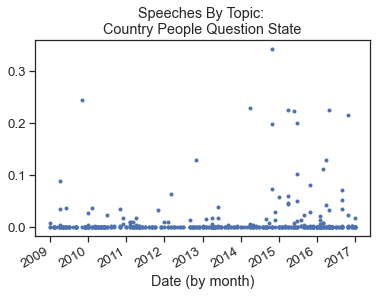

In [197]:
topic_number = 5

topic_label = " ".join(topics[topic_number][:4])

df_speech[topic_label].plot(style='.', title=f'Speeches By Topic: \n{topic_label.title()}')

<AxesSubplot:title={'center':'Speeches By Topic: \nBusiness Country State World'}, xlabel='Date (by month)'>

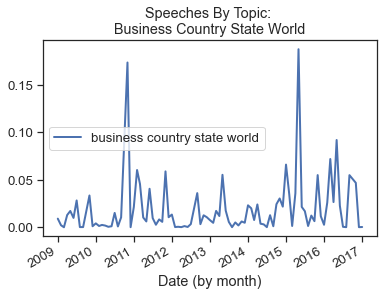

In [198]:
topic_number = 9

topic_label = " ".join(topics[topic_number][:4])

df_speech.groupby(df_speech.index)[[topic_label]].mean().plot(title=f'Speeches By Topic: \n{topic_label.title()}', linewidth=2)

<AxesSubplot:title={'center':'Speeches By Topic: \nPresident Question Year Issue'}, xlabel='Date (by month)'>

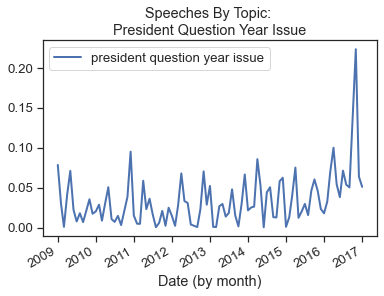

In [199]:
topic_number = 8

topic_label = " ".join(topics[topic_number][:4])

df_speech.groupby(df_speech.index)[[topic_label]].mean().plot(title=f'Speeches By Topic: \n{topic_label.title()}', linewidth=2)

<AxesSubplot:title={'center':'Speeches By Topic: \nWar Force Troop Security'}, xlabel='Date (by month)'>

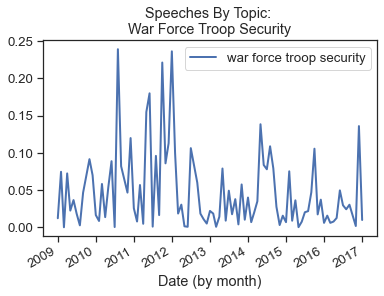

In [200]:
topic_number = 4

topic_label = " ".join(topics[topic_number][:4])

df_speech.groupby(df_speech.index)[[topic_label]].mean().plot(title=f'Speeches By Topic: \n{topic_label.title()}', linewidth=2)

# Indicators regarding topics

In [214]:
import wbdata
import datetime
date = (datetime.datetime(2008, 1, 1), datetime.datetime(2022, 1, 1))

## Military expenditure (% of GDP)

In [216]:
wbdata.search_countries('united')

In [ ]:
wbdata.search_indicators("military expenditure")

In [ ]:
indicators = {"MS.MIL.XPND.CD":"Military expenditure (current USD)"}
military = wbdata.get_dataframe(indicators, country = "USA", convert_date = True, data_date = date)
military.head()

In [ ]:
military.plot()
plt.title('Military expenditure (current USD)')
plt.xlabel('Year')
plt.ylabel('Military expenditure (current USD)')
plt.show()

##  Health

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


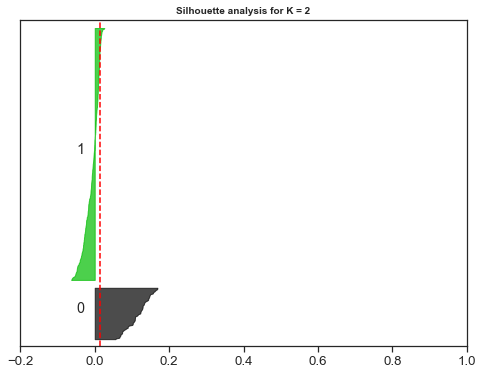

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


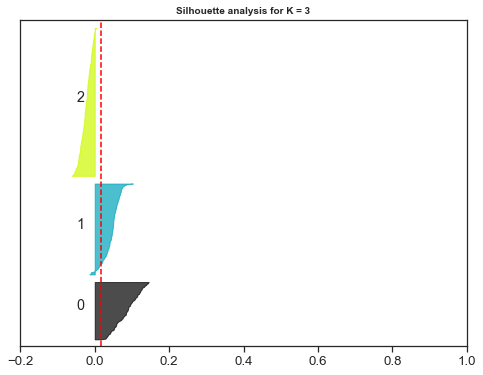

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


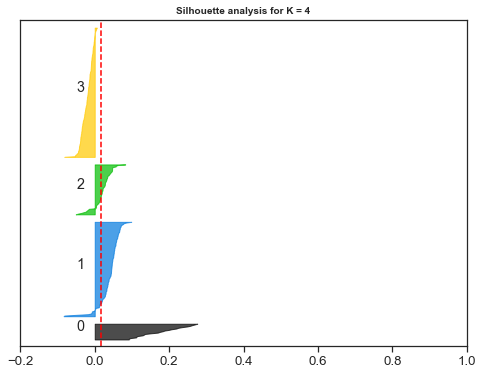

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


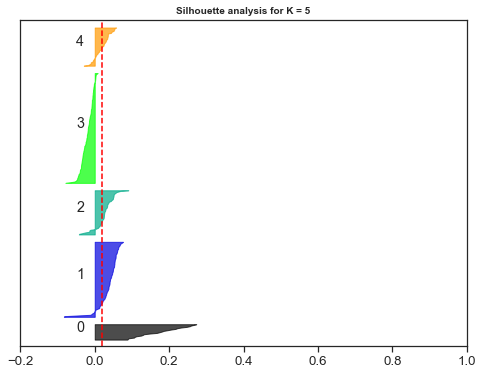

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


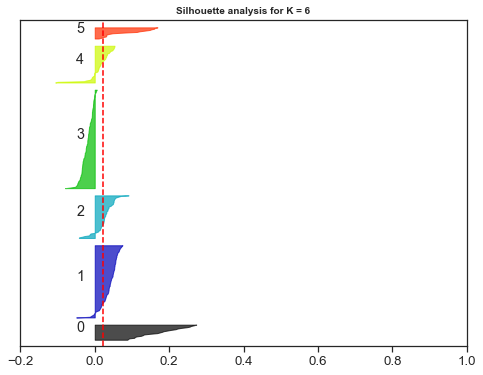

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


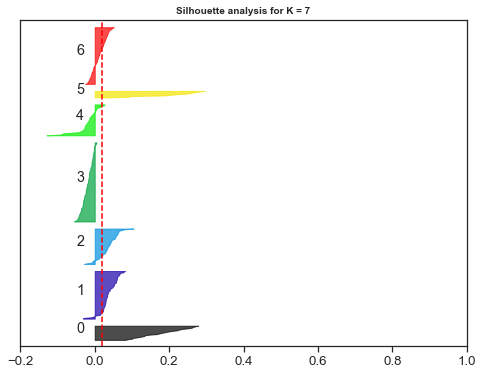

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


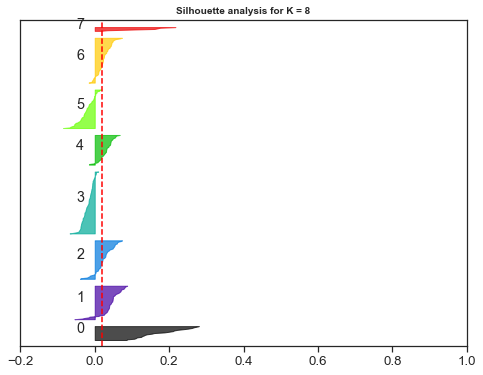

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


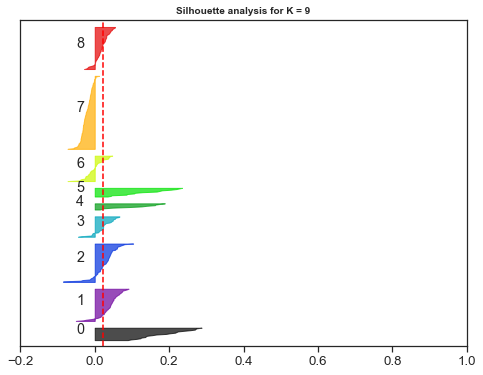

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


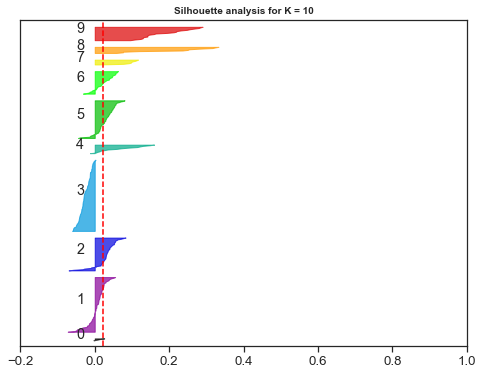

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


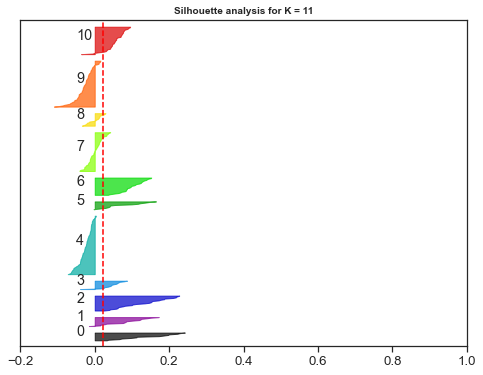

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


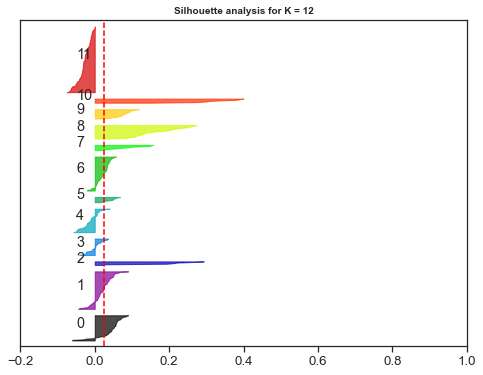

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


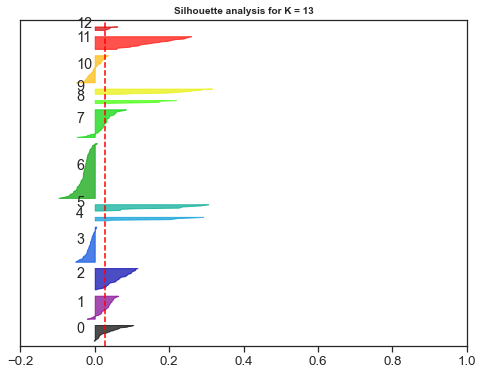

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


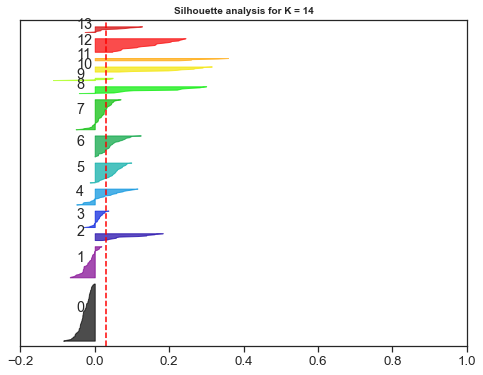

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


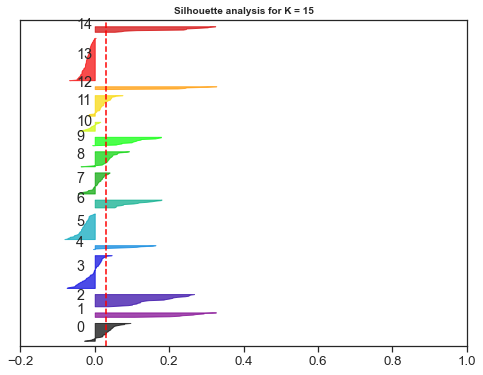

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


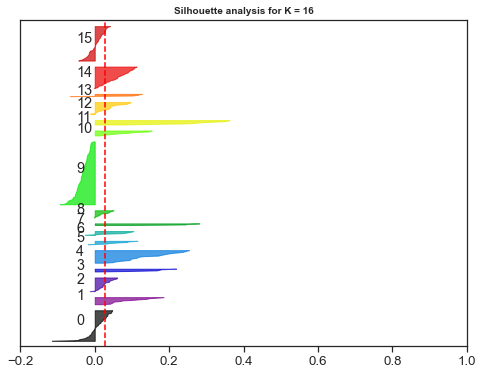

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


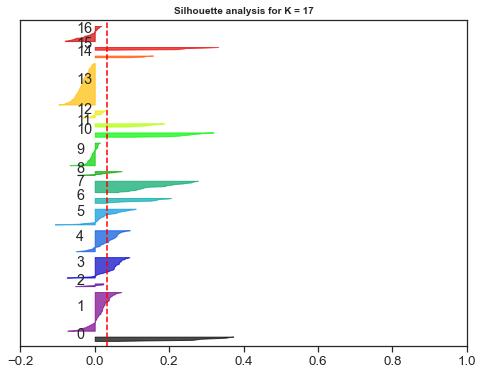

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


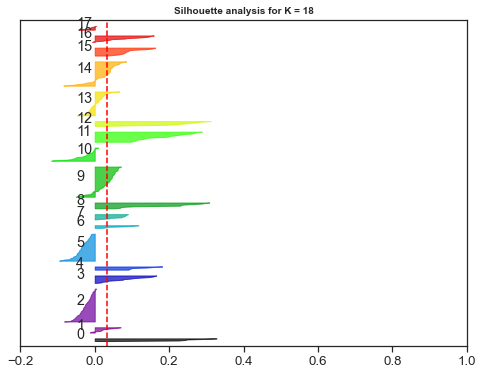

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


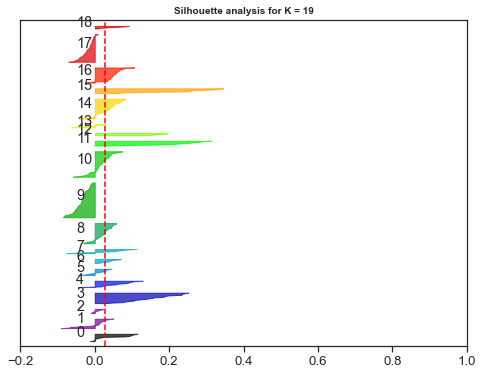

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


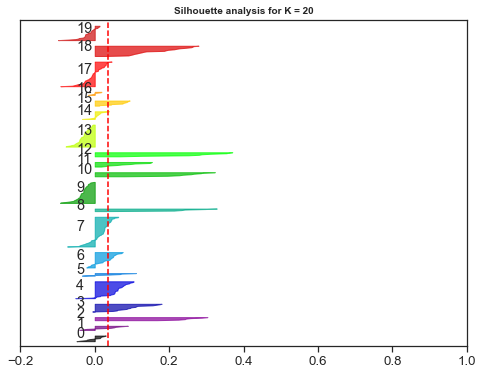

In [217]:
wbdata.search_indicators("health expenditure")

In [ ]:
indicators = {"SH.XPD.GHED.GE.ZS":"Domestic general government health expenditure (% of general government expenditure)"}
health = wbdata.get_dataframe(indicators, country = "USA", convert_date = True, data_date = date)

In [218]:
health.plot()
plt.title('Domestic general government health expenditure (% of general government expenditure)')
plt.xlabel('Year')
plt.ylabel('Domestic general government health expenditure (% of general government expenditure)')
plt.show()

## Unemployment

In [ ]:
wbdata.search_indicators("election")

In [ ]:
indicators = {"SH.XPD.GHED.GE.ZS":"Domestic general government health expenditure (% of general government expenditure)"}
health = wbdata.get_dataframe(indicators, country = "USA", convert_date = True, data_date = date)
health.plot()
plt.title('Domestic general government health expenditure (% of general government expenditure)')
plt.xlabel('Year')
plt.ylabel('Domestic general government health expenditure (% of general government expenditure)')
plt.show()

## Education

## Environment

## Race equality